test multi-task optimisation in 2D

use branch `multi-task` to run this notebook!

In [1]:
import numpy as np
from boss.bo.bo_main import BOMain

In [2]:
import matplotlib.pyplot as plt

In [3]:
seed=260422

utilities:

In [4]:
import GPy

In [5]:
def load_model(filename):

    # load saved data
    saved=np.load(filename)
    dim=saved['X'].shape[1]

    # create kernel
    k=GPy.kern.StdPeriodic(input_dim=dim,ARD1=True,ARD2=True)

    # create mean function
    mf=GPy.mappings.Constant(dim,1)

    # create model
    m=GPy.models.GPRegression(saved['X'],saved['Y'],kernel=k,mean_function=mf)

    # set model params
    m[:]=saved['params']
    m.fix()
    m.parameters_changed()

    return m

optimisation task:

In [6]:
def f_0(x):
    return unknown_model_0.predict(np.atleast_2d(x))[0]

def f_1(x):
    return unknown_model_1.predict(np.atleast_2d(x))[0]

In [7]:
unknown_model_0=load_model('../models/model_2D_E0.npz')
unknown_model_1=load_model('../models/model_2D_E1.npz')
bounds=[[-50.0, 310.0]]*2

plot:

In [8]:
xp = np.linspace(-50, 310, 361)
levels = 25

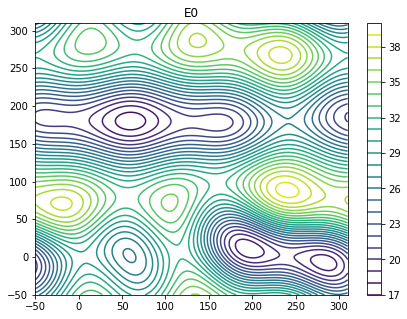

In [9]:
x1, x2 = np.meshgrid(xp,xp) 
yp = f_0(np.column_stack((x1.ravel(),x2.ravel())))
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E0');

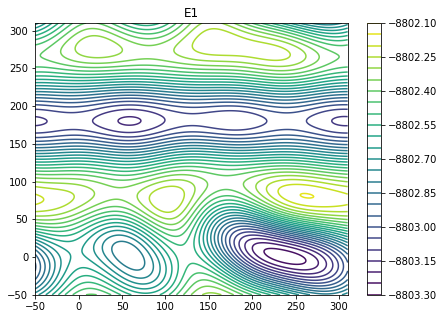

In [10]:
yp = f_1(np.column_stack((x1.ravel(),x2.ravel())))
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.title('E1');

## baseline optimisation

In [11]:
bo_1 = BOMain(
    f_1, 
    bounds,
    yrange=[0, 1],
    kernel='stdp',
    initpts=5,
    iterpts=20,
    seed=seed
)

In [12]:
%time res_1 = bo_1.run()

CPU times: user 7.8 s, sys: 319 ms, total: 8.12 s
Wall time: 7.44 s


best observed value:

In [13]:
[res_1.xbest, res_1.ybest]

[array([232.33012178,   8.54373132]), -8803.259338121286]

estimated minimum and predicted minimum value:

In [14]:
[res_1.xmin, res_1.fmin]

[array([242.07752939,   1.13821656]), -8803.28036060611]

evaluate estimated minimum:

In [15]:
f_1(res_1.xmin)

array([[-8803.27526132]])

plot:

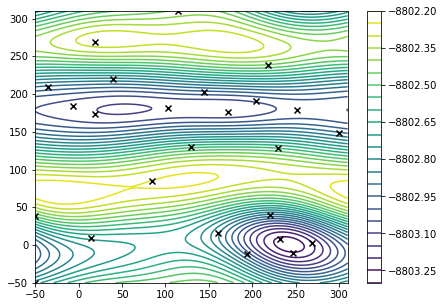

In [16]:
yp = bo_1.model.predict(np.column_stack((x1.ravel(),x2.ravel())))[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_1.model.X[:,0],bo_1.model.X[:,1], marker='x', color='k', zorder=10);

## multi-task optimisation

associate acquisitions with a cost:

In [17]:
cost_0 = 0.1
cost_1 = 1

add maximum cost limit to optimisation:

In [18]:
maxcost = 25 * cost_1

In [19]:
bo_2 = BOMain(
    [f_1, f_0], 
    bounds,
    num_tasks=2,
    kernel='stdp',
    initpts=5,
    iterpts=100,
    seed=seed,
    maxcost=maxcost,
    acqcost=[cost_1, cost_0]
)

In [20]:
%time res_2 = bo_2.run()

CPU times: user 36.6 s, sys: 2.58 s, total: 39.2 s
Wall time: 26.1 s


In [21]:
[res_2.xbest, res_2.ybest]

[array([227.55849745,   1.68031092]), -8803.272062090366]

In [22]:
[res_2.xmin, res_2.fmin]

[array([238.34732087,   0.67749018]), -8803.277268616823]

test errors:

evaluate estimated minimum:

In [23]:
f_1(res_2.xmin)

array([[-8803.27706004]])

plot:

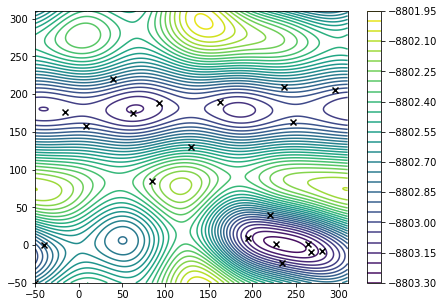

In [24]:
yp = bo_2.model.predict(np.column_stack((x1.ravel(),x2.ravel())))[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_2.model.X[:,0], bo_2.model.X[:,1], marker='x', color='k', zorder=10);

support task:

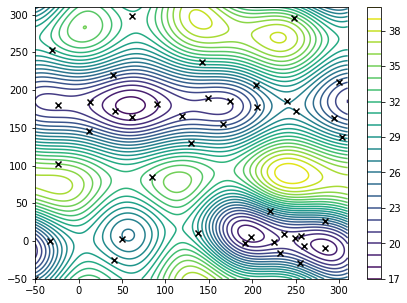

In [25]:
yp = bo_2.model.predict(np.column_stack((x1.ravel(),x2.ravel())), index=1)[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_2.model.get_X(index=1)[:,0],bo_2.model.get_X(index=1)[:,1], marker='x', color='k', zorder=10);

compare acquisition locations:

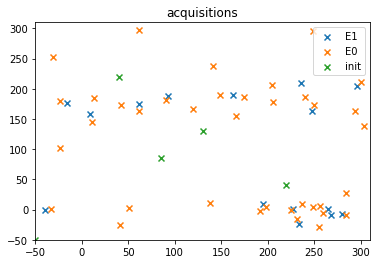

In [26]:
plt.scatter(bo_2.model.get_X(index=0)[bo_2.initpts[0]:,0],bo_2.model.get_X(index=0)[bo_2.initpts[0]:,1],marker='x',label='E1')
plt.scatter(bo_2.model.get_X(index=1)[bo_2.initpts[1]:,0],bo_2.model.get_X(index=1)[bo_2.initpts[1]:,1],marker='x',label='E0')
plt.scatter(bo_2.model.get_X(index=0)[:bo_2.initpts[0],0],bo_2.model.get_X(index=0)[:bo_2.initpts[0],1],marker='x',label='init')
plt.xlim(bounds[0])
plt.ylim(bounds[1])
plt.legend()
plt.title('acquisitions');

note: num evaluations with each task

In [27]:
len(bo_2.model.get_X(index=0)) # E1

20

In [28]:
len(bo_2.model.get_X(index=1)) # E0

42

selected task indices are also available as model attribute:

In [29]:
np.bincount(bo_2.model.inds)

array([20, 42])

add example prior distributions as discussed in multi_init notebook:

In [30]:
W_prior='gaussian'
W_mean = 0.5
W_std = 0.2
kappa_prior ='gamma'
kappa_shape = 1
kappa_rate = 8

In [31]:
bo_3 = BOMain(
    [f_1, f_0], 
    bounds,
    num_tasks=2,
    kernel='stdp',
    initpts=5,
    iterpts=100,
    seed=seed,
    W_prior=W_prior,
    W_priorpar=[W_mean, W_std],
    kappa_prior=kappa_prior,
    kappa_priorpar=[kappa_shape, kappa_rate],
    maxcost=maxcost,
    acqcost=[cost_1, cost_0]
)

In [32]:
%time res_3 = bo_3.run()

CPU times: user 39.9 s, sys: 2.53 s, total: 42.4 s
Wall time: 29.6 s


In [33]:
[res_3.xbest, res_3.ybest]

[array([228.99968529,   5.03885157]), -8803.272456074903]

In [34]:
[res_3.xmin, res_3.fmin]

[array([236.48825549,   0.96968537]), -8803.275867427958]

evaluate estimated minimum:

In [35]:
f_1(res_3.xmin)

array([[-8803.27708965]])

plot:

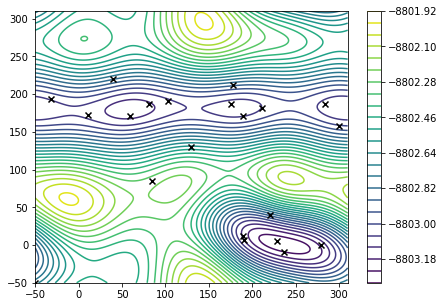

In [36]:
yp = bo_3.model.predict(np.column_stack((x1.ravel(),x2.ravel())))[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_3.model.X[:,0],bo_3.model.X[:,1], marker='x', color='k', zorder=10);

num evaluations:

In [37]:
np.bincount(bo_3.model.inds)

array([21, 40])

test recommended setup:

In [38]:
base_rate = 2/0.5**2

In [39]:
W_prior='gaussian'
W_mean = 0.9 * np.sqrt(2 / base_rate)
W_std = 0.5 / np.sqrt(base_rate)

In [40]:
bo_4 = BOMain(
    [f_1, f_0], 
    bounds,
    num_tasks=2,
    kernel='stdp',
    initpts=5,
    iterpts=100,
    seed=seed,
    W_prior=W_prior,
    W_priorpar=[W_mean, W_std],
    maxcost=maxcost,
    acqcost=[cost_1, cost_0]
)

In [41]:
%time res_4 = bo_4.run()

CPU times: user 46.5 s, sys: 2.92 s, total: 49.4 s
Wall time: 33.5 s


In [42]:
[res_4.xbest, res_4.ybest]

[array([233.04868207,   3.32761172]), -8803.275517580194]

In [43]:
[res_4.xmin, res_4.fmin]

[array([233.01084968,   2.0240653 ]), -8803.27621495703]

evaluate estimated minimum:

In [44]:
f_1(res_4.xmin)

array([[-8803.27635116]])

plot:

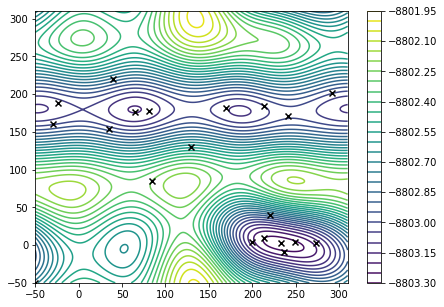

In [45]:
yp = bo_4.model.predict(np.column_stack((x1.ravel(),x2.ravel())))[0]
plt.figure(figsize=(7,5))
cset = plt.contour(xp, xp, yp.reshape(len(xp),len(xp)), levels=levels)
plt.colorbar(cset)
plt.scatter(bo_4.model.X[:,0],bo_4.model.X[:,1], marker='x', color='k', zorder=10);

num evaluations:

In [46]:
np.bincount(bo_4.model.inds)

array([20, 41])